In [2]:
#| default_exp volume_comparison
# Diffusion Curvature utils
from diffusion_curvature.kernels import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.datasets import *
from diffusion_curvature.utils import *
# Python necessities
import numpy as np
from fastcore.all import *
import matplotlib.pyplot as plt
# Notebook Helpers
from nbdev.showdoc import *
from tqdm.notebook import trange, tqdm
%load_ext autoreload
%autoreload 2

# Scalar Curvature by Volume Comparison
> Based off of Hickock's 2023 method, but using diffusion-based volume estimation.

In our 'Volume Estimation' notebook, we saw that self-diffusion can provide a reasonable estimate of the volume of geodesic balls -- at least on euclidean manifolds, and with a few caveats. Here, we take advantage of this by using a classical formula that relates the ratio of manifold volumes to euclidean volumes to the scalar curvature:

$$
\frac{\operatorname{vol}\left(B^M(x, r)\right)}{\operatorname{vol}\left(B^E(r)\right)}=1-\frac{S(x)}{6(n+2)} r^2+\mathcal{O}\left(r^4\right)
$$

We're inspired here by Hickock's 2023 method, which uses uses density estimation and shortest-path distances to estimate the manifold volume at several scales, and then fits a quadratic to the resulting ratios and extracts from it the scalar curvature. Diffusion has the potential to strengthen this process further, principally by reducing the reliance on shortest-path distances and density estimation. As a nice side effect, this enables Hickock's method to be generalized to graphs that don't come with attached point clouds.

In [3]:
def volume_ratio(A,B):
    """Removes constant offset from both A and B before taking ratio,"""
    m = min(A)
    A = A - np.min(A) + 1e-12
    B = B - np.min(B) + 1e-12
    return A/B

In [4]:
#|export
import numpy as np
from diffusion_curvature.volume import volume_via_heat_at_scales, actual_euclidean_volumes_at_radii
def volume_comparisons_of_graph_at_idx(
        G, # pygsp graph
        idx, # node idx to get comparisons from
        dim, # intrinsic dimension of graph/manifold
        ts, # diffusion times at which to give comparison
):
    """Returns the ratio of Vol(B_m)/Vol(B_E) at each of the times"""
    vols_manifold = volume_via_heat_at_scales(G,idx,ts)
    radii = np.sqrt(ts)
    vols_euclidean = actual_euclidean_volumes_at_radii(dim, radii)
    return vols_manifold/vols_euclidean

In [5]:
#|export
def extract_scalar_curvature(
        radii, 
        volume_ratios,
        dim,
        verbose=False
        ):
    coeffs = np.polyfit(radii, volume_ratios, deg=3)
    if verbose: print(f"Coeffs are {coeffs}")
    S = -coeffs[1]*6*(dim+2)
    return S

### The Plane
This is the most basic example. The volume ratios here should be flat.

In [26]:
(np.arange(1,11)/3)**2

array([ 0.11111111,  0.44444444,  1.        ,  1.77777778,  2.77777778,
        4.        ,  5.44444444,  7.11111111,  9.        , 11.11111111])

In [28]:
from diffusion_curvature.graphs import *
def ratios_of_plane(idx):
    X = plane(10000)
    G = get_alpha_decay_graph(X)  
    ts = (np.arange(1,11)/3)**2
    h_ratios = volume_comparisons_of_graph_at_idx(G,idx,dim=2,ts=ts)
    return h_ratios

In [29]:
plane_ratios_in_bulk = np.array(
    perform_trials(ratios_of_plane,n_trials=50, idx=0))

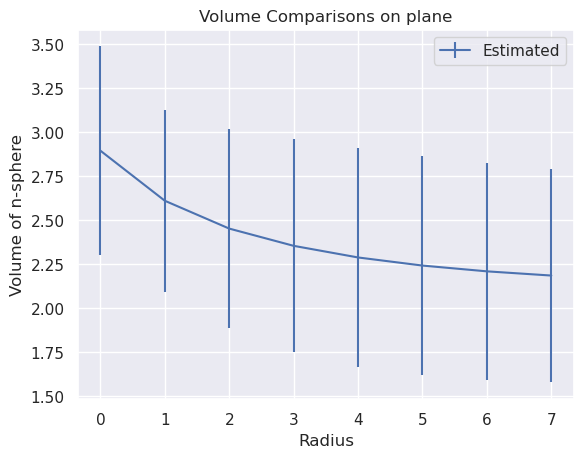

In [8]:
plot_array(plane_ratios_in_bulk,"Volume Comparisons on plane")

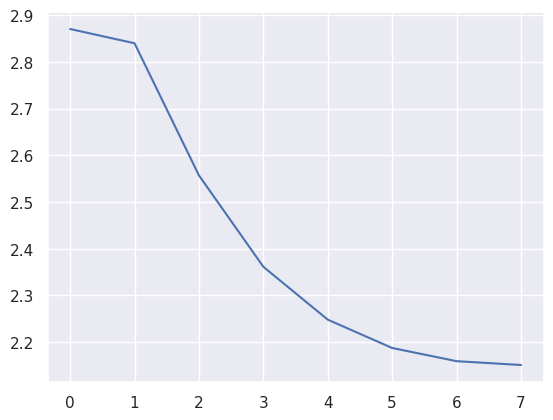

In [9]:
plt.plot(plane_ratios_in_bulk[0])

In [10]:
from diffusion_curvature.datasets import torus
from diffusion_curvature.graphs import *
X, ks = torus(10000, use_guide_points=True)
G_torus = get_alpha_decay_graph(X)

In [11]:
ts = np.array([1,2,3,4,5,6,7])**2
torus_ratios = volume_comparisons_of_graph_at_idx(G_torus,0,2,ts)

/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion_curvature/diffusion_curvature/heatkernel.py:33: RuntimeWarning: overflow encountered in scalar power
  * (C ** (K + 1))
/home/piriac/Pumberton/Workshop/21-SUMRY-Curvature/diffusion_curvature/diffusion_curvature/heatkernel.py:31: RuntimeWarning: invalid value encountered in scalar divide
  2


In [12]:
extract_scalar_curvature(np.sqrt(ts), torus_ratios, 2, verbose=True)

Coeffs are [-0.01564417  0.21658739 -0.91603003  3.05417879]


-5.198097451081673

## An experiment: the torus in detail
The torus contains regions of both negative and positive curvature, allowing us to examine how the method responds to each of these.

In [13]:
def ratios_of_torus(idx):
    X, ks = torus(10000, use_guide_points=True)
    G_torus = get_alpha_decay_graph(X)  
    ts = [1,2,3,4,5,6,7,8]
    torus_ratios = volume_comparisons_of_graph_at_idx(G_torus,idx,dim=2,ts=ts)
    return torus_ratios

In [14]:
from diffusion_curvature.utils import perform_trials
torus_ratios_in_bulk = np.array(
    perform_trials(ratios_of_torus,n_trials=50, idx=0))

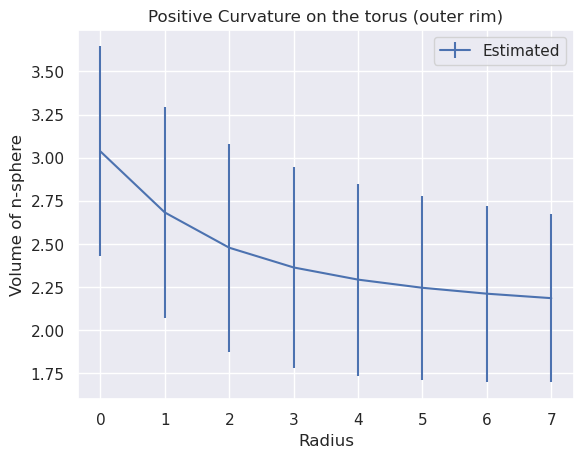

In [15]:
plot_array(torus_ratios_in_bulk, title="Positive Curvature on the torus (outer rim)")

In [16]:
from diffusion_curvature.utils import perform_trials
torus_ratios_in_bulk = np.array(
    perform_trials(ratios_of_torus,n_trials=50, idx=1))

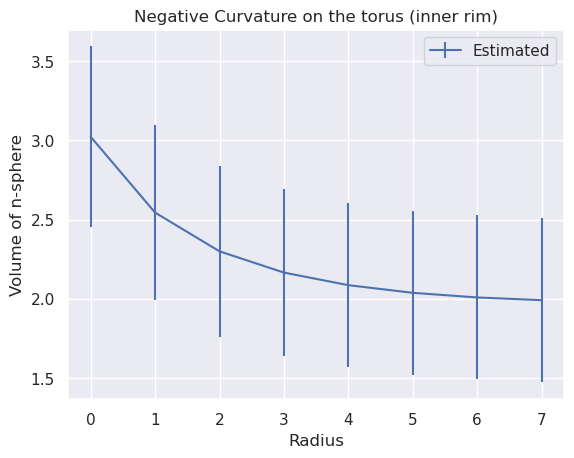

In [17]:
plot_array(torus_ratios_in_bulk, title="Negative Curvature on the torus (inner rim)")

## Experiment with different manifolds

### The Saddle

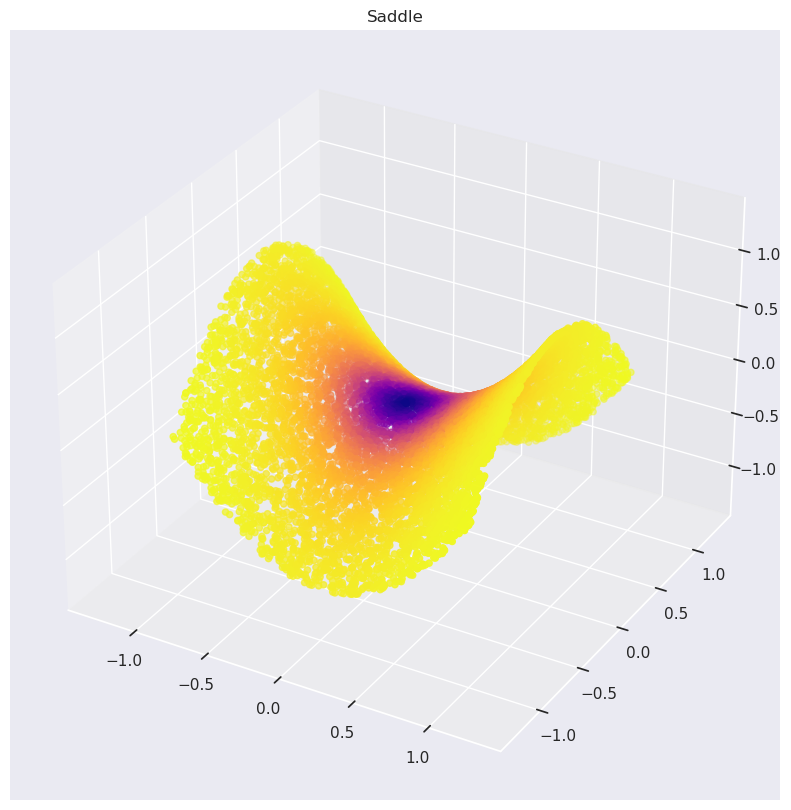

In [18]:
X, ks = paraboloid(10000, use_guide_points=True)
plot_3d(X,ks,"Saddle")

In [19]:
def ratios_of_saddle(idx):
    X, ks = paraboloid(10000, use_guide_points=True)
    G = get_alpha_decay_graph(X)  
    ts = [1,2,3,4,5,6,7,8]
    h_ratios = volume_comparisons_of_graph_at_idx(G,idx,dim=2,ts=ts)
    return h_ratios

In [20]:
saddle_ratios_in_bulk = np.array(
    perform_trials(ratios_of_saddle,n_trials=50, idx=0))

KeyboardInterrupt: 

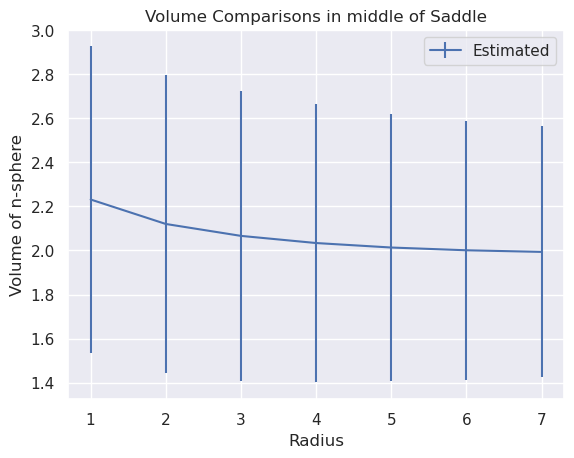

In [ ]:
plot_array(saddle_ratios_in_bulk,"Volume Comparisons in middle of Saddle")

### The Sphere

In [ ]:
def ratios_of_sphere(idx):
    X, ks = sphere(10000, use_guide_points=True)
    G = get_alpha_decay_graph(X)  
    ts = [1,2,3,4,5,6,7,8]
    h_ratios = volume_comparisons_of_graph_at_idx(G,idx,dim=2,ts=ts)
    return h_ratios

In [ ]:
sphere_ratios_in_bulk = np.array(
    perform_trials(ratios_of_sphere,n_trials=50, idx=0))

/tmp/ipykernel_159366/1071188373.py:5: RuntimeWarning: invalid value encountered in divide
  return A/B
/tmp/ipykernel_159366/1071188373.py:5: RuntimeWarning: invalid value encountered in divide
  return A/B
/tmp/ipykernel_159366/1071188373.py:5: RuntimeWarning: invalid value encountered in divide
  return A/B
/tmp/ipykernel_159366/1071188373.py:5: RuntimeWarning: invalid value encountered in divide
  return A/B
/tmp/ipykernel_159366/1071188373.py:5: RuntimeWarning: invalid value encountered in divide
  return A/B
/tmp/ipykernel_159366/1071188373.py:5: RuntimeWarning: invalid value encountered in divide
  return A/B
/tmp/ipykernel_159366/1071188373.py:5: RuntimeWarning: invalid value encountered in divide
  return A/B
/tmp/ipykernel_159366/1071188373.py:5: RuntimeWarning: invalid value encountered in divide
  return A/B
/tmp/ipykernel_159366/1071188373.py:5: RuntimeWarning: invalid value encountered in divide
  return A/B
/tmp/ipykernel_159366/1071188373.py:5: RuntimeWarning: invalid v

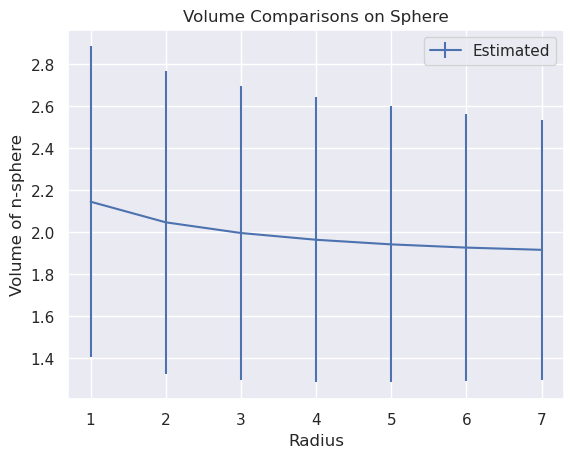

In [ ]:
plot_array(sphere_ratios_in_bulk,"Volume Comparisons on Sphere")

In [ ]:
#|export
from tqdm.notebook import trange
def scalar_curvatures_of_graph(
    G, 
    dim,
    ts = np.arange(1,10)
):
    ks = np.empty(G.L.shape[0])
    for i in trange(len(ks)):
        ratios = volume_comparisons_of_graph_at_idx(
            G,
            i,
            dim,
            ts
        )
        ks[i] = extract_scalar_curvature(np.sqrt(ts),ratios,dim)
    return ks

In [ ]:
ks_torus = scalar_curvatures_of_graph(G_torus,dim=2)

  0%|          | 0/4938 [00:00<?, ?it/s]

/tmp/ipykernel_159366/1071188373.py:5: RuntimeWarning: invalid value encountered in divide
  return A/B


KeyboardInterrupt: 

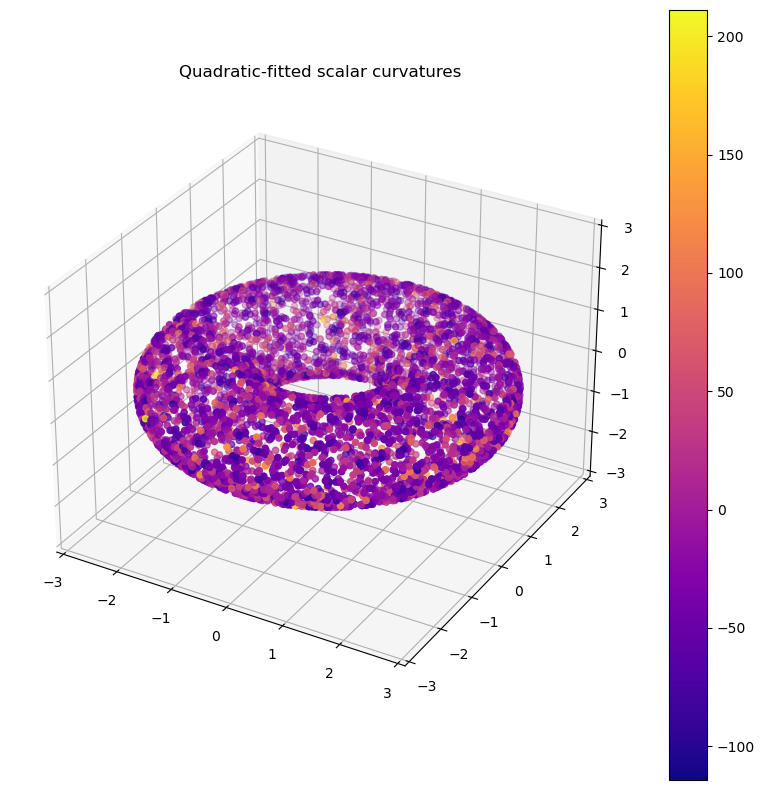

In [ ]:
plot_3d(X,ks_torus,"Quadratic-fitted scalar curvatures", colorbar=True)